In [554]:
import pandas as pd
import numpy as np
import seaborn as sns
import prophet
import datetime as DT
import holidays

from matplotlib import pyplot as plt
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from sklearn.metrics import mean_absolute_percentage_error as MAPE

<h5>Задача:</h5>
По имеющимся данным о продажах построить прогноз продаж с горизонтом 28 дней.

Данную модель бизнес использует: 

- Для выставления планов продаж отдела.
- Для формирования ценового предложения основных продуктовых линеек

Используемые данные предварительно анонимизированны и изменены без потери сути работы.

------------------

In [555]:
# Загружаем данные для обучения
train = pd.read_csv('train_data.csv')
# Загружаем заранее отделенные данные для итоговой оценки качества модели
test = pd.read_csv('test_data.csv')

In [556]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1971 entries, 0 to 1970
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      1971 non-null   object 
 1   y       1971 non-null   float64
dtypes: float64(1), object(1)
memory usage: 30.9+ KB


In [557]:
train.describe()

,y
count,1.971000e+03
mean,1.384603e+06
std,1.286059e+06
min,-3.378939e+05
25%,0.000000e+00
50%,1.361265e+06
75%,2.208707e+06
max,6.882846e+06


In [558]:
# Аномальная точка - 'нерабочий день' минус - возврат предоплаченных средств клиенту.
train[train['y'] < 0]

,ds,y
828,2020-04-16,-337893.9


In [559]:
# Аномальную точку выбросим из данных.
train.loc[828, 'y'] = None

# Строчный формат в дату
train['ds'] = pd.to_datetime(train.ds)
test['ds'] = pd.to_datetime(test.ds)

<h5>Посмотрим на данные графически</h5>

In [560]:
# Года наблюдений
train.ds.dt.to_period('y').unique()

<PeriodArray>
['2018', '2019', '2020', '2021', '2022', '2023']
Length: 6, dtype: period[A-DEC]

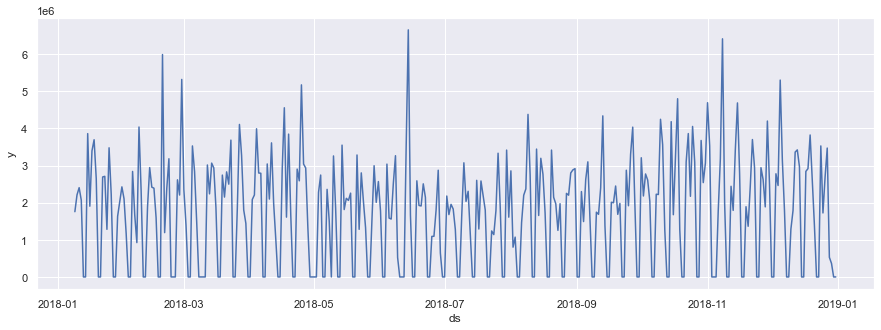

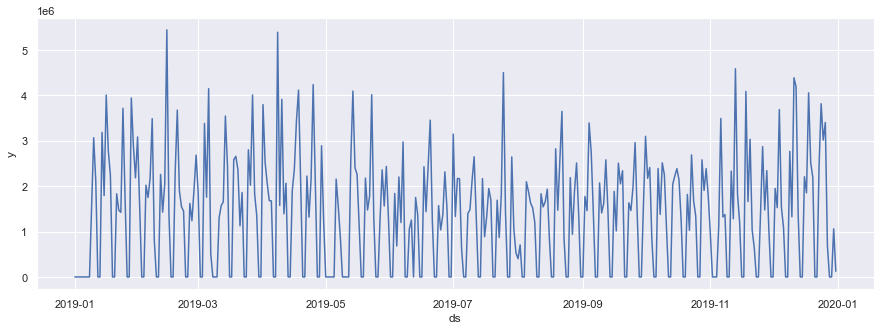

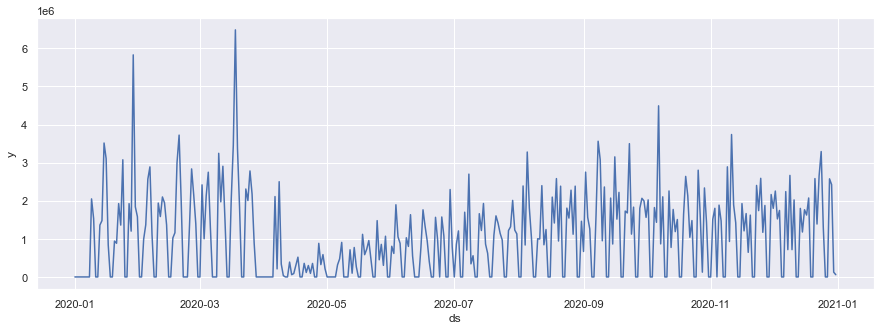

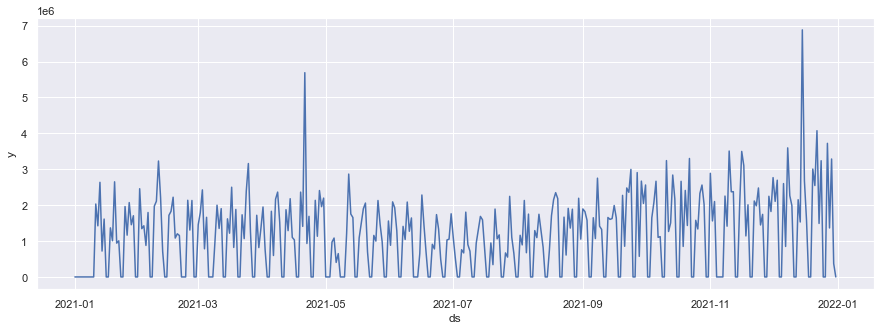

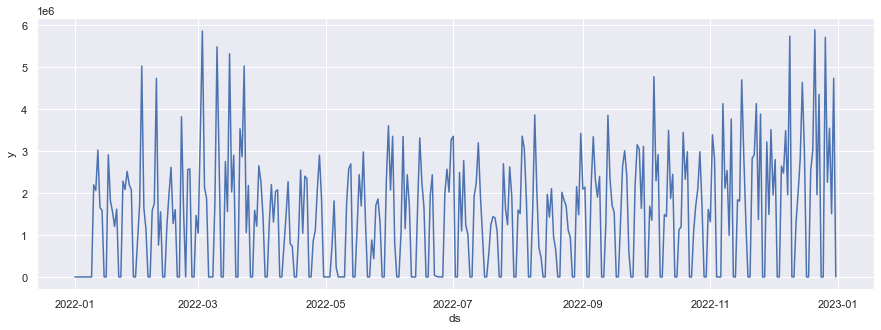

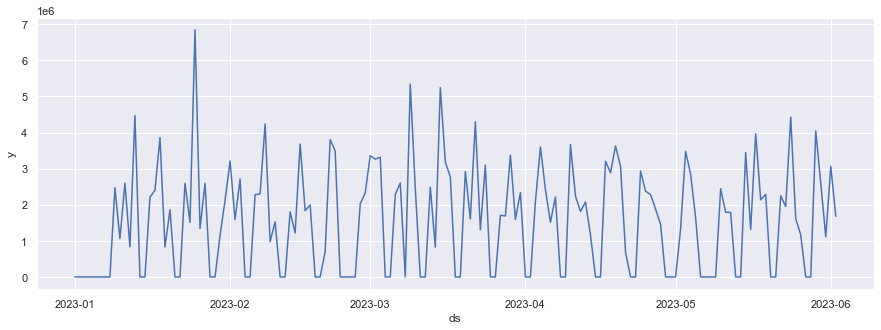

In [561]:
sns.set(rc={'figure.figsize':(15,5)}) # Графики крупнее

# Строим графики продаж для каждого года наблюдений
for year in train.ds.dt.to_period('y').unique():
    sns.lineplot(data = train[train.ds.dt.to_period('y') == year], x = 'ds', y = 'y')
    plt.show()

>В выходные и праздничные дни компания не работает, продажи в эти дни отмечены как '0'. 

>Для предиктичных моделей такие дни нужно разметить как пропуски, иначе модель будет считать что компания работала но ничего не продала. Что ухудшит точность прогноза.

In [562]:
# Перезапишем нули на пропуски
train.loc[train.y == 0, 'y'] = None

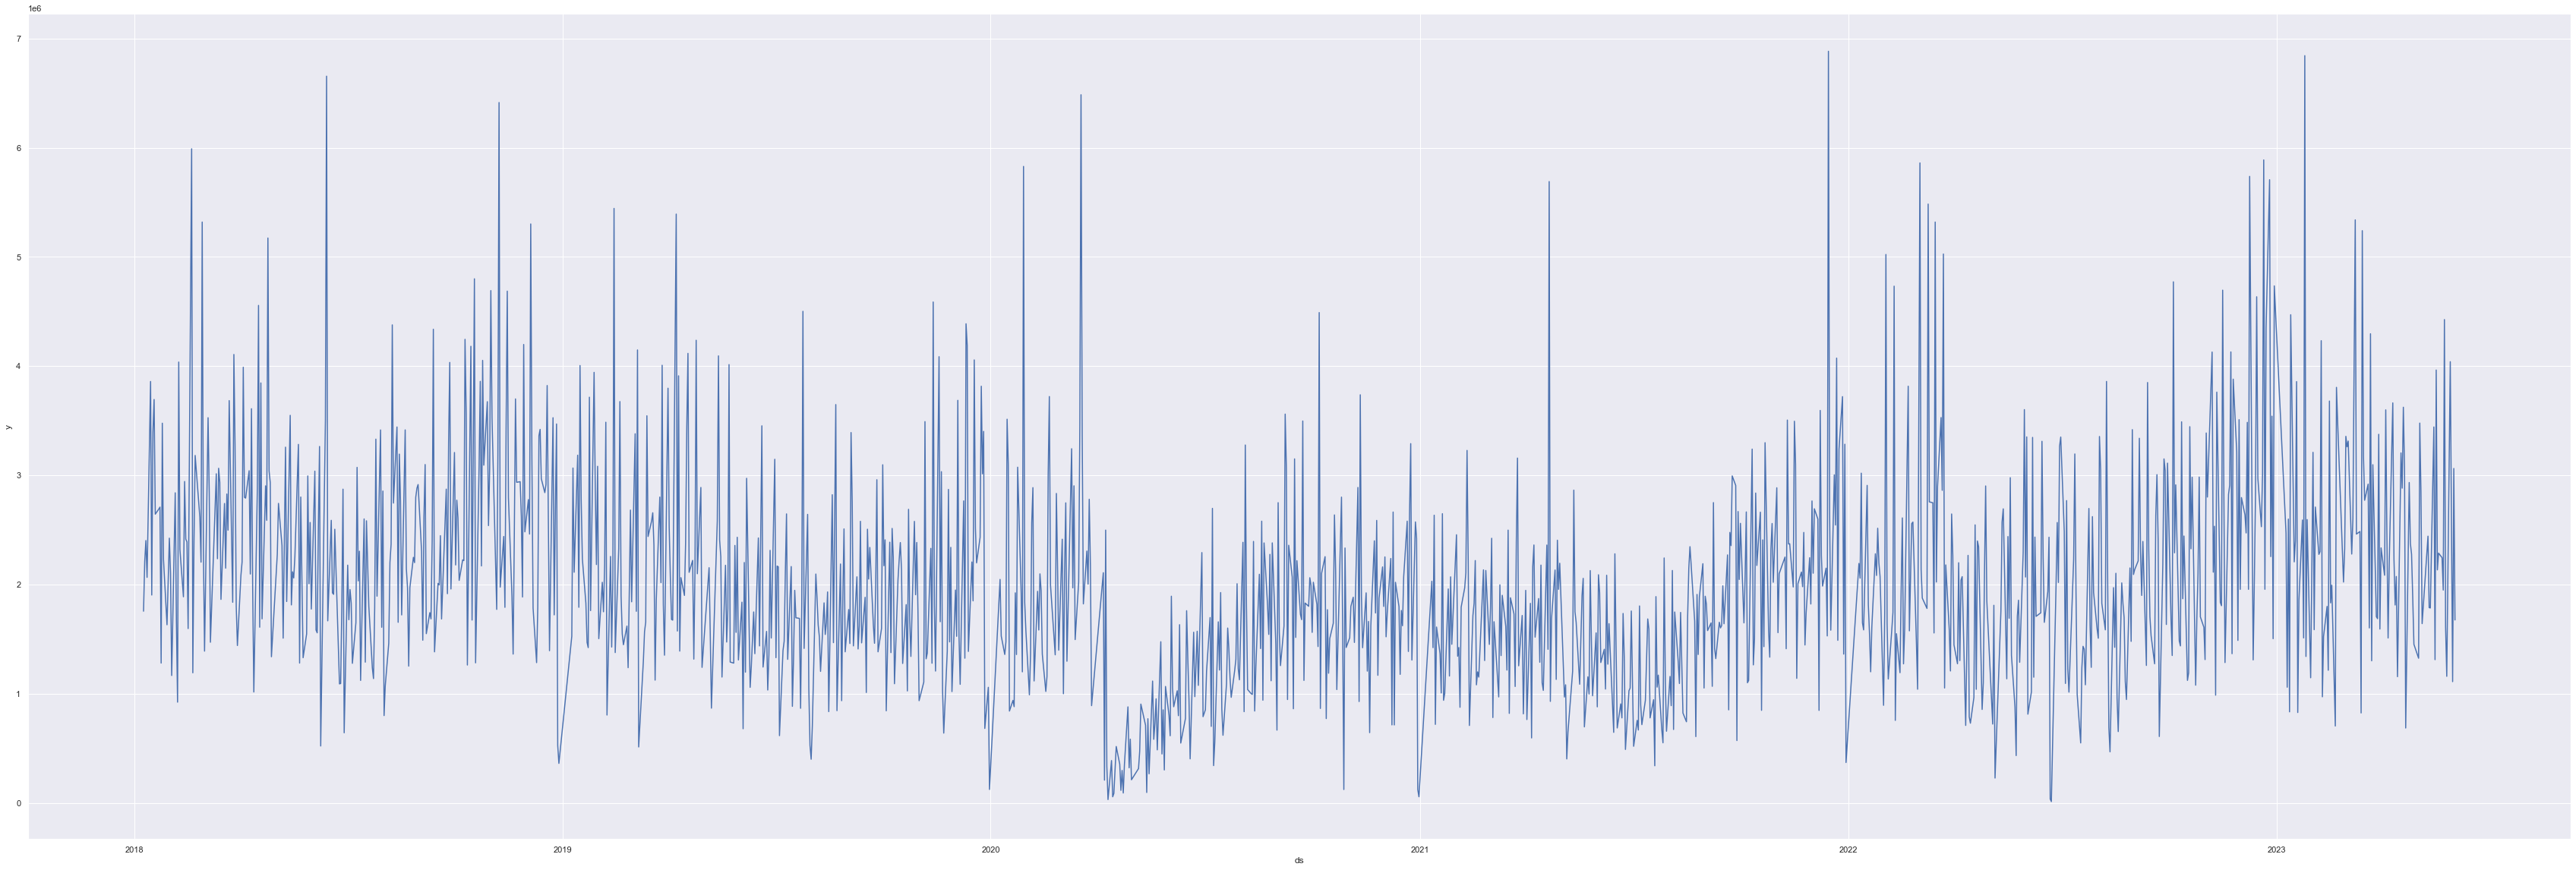

In [563]:
# Визуализируем весь диапазон последовательно
plt.figure(figsize=(60, 20))
sns.lineplot(data = train, x = 'ds', y = 'y')
plt.show()

-----------

<h5>Строить модель будем при помощи библиотеки Prophet.</h5>

Будем учитывать:
- сезонности
- праздничные и выходные дни РФ.
- локдауны в РФ во время ковида
- день недели
- курс евро (так как товар импортный)
- отпускные цены на основной ряд продукции (т.к. прайслисты закреплены в рублях, и не всегда следуют за курсовой разницей)

Метрикой итогового прогноза выберем MAPE из-за простоты интерпретации для заказчика.

Метрикой качества при кросс-валидации выберем MdAPE так как имеем постоянные пики продаж значительно выше тренда, таким образом исключим выбросы при оценки.

--------

<h3> Подготовка данных регрессоров для загрузки в модель </h3> 

In [564]:
# Добавляем данные- регрессоры

# День недели
train['dow'] = train['ds'].dt.day_of_week.astype(str)
test['dow'] = test['ds'].dt.day_of_week.astype(str)

# Курс евро выгружаем с ЦБ рф запросом с 01-01-2017 по текущую дату
Euro = pd.read_xml(f'https://www.cbr.ru/scripts/XML_dynamic.asp?date_req1=01/01/2017&date_req2=01/01/2100&VAL_NM_RQ=R01239')

In [565]:
# Даты в формат дат
Euro['Date'] = pd.to_datetime(Euro['Date'], dayfirst=True)
Euro = Euro.rename(columns={'Date': 'ds'})

# Оставляем только нужные колонки
Euro = Euro[['ds', 'Value']]

# Сам курс написан через разделитель ',' меняем на '.' и преобразуем в число с плавающей точкой 
Euro['Value'] = Euro.Value.str.replace(',', '.').astype(float)

In [566]:
# Весь диапазон дат, чтобы проставить фиксироыванный курс на время выходных и праздников
all_dates =  pd.DataFrame(pd.date_range(start=Euro['ds'].min(), end=Euro['ds'].max(), freq='1d'), columns=['ds'])

# Курс включая выходные дни
Euro = all_dates.merge(Euro, how='left').ffill()

In [567]:
# Готовим фрейм данных о праздниках из библиотеки Hollidays
data = pd.DataFrame(columns = ['ds', 'name'])
for year in [2018, 2019, 2020, 2021, 2022, 2023]:
    for p in holidays.RU(years = year).items():
        data.loc[len(data)] = [p[0], p[1]]

# Дату в формат дат
data['ds'] = pd.to_datetime(data['ds'])

In [568]:
# Смотрим на хвост фрейма
data.tail(5)

,ds,name
81,2023-03-08,Международный женский день
82,2023-05-01,Праздник Весны и Труда
83,2023-05-09,День Победы
84,2023-06-12,День России
85,2023-11-04,День народного единства


In [569]:
# В данных о праздниках помещаем данные о выходных и нерабочих днях из производственных календарей соответствующих годов
hol= pd.concat([pd.read_csv('2018calendar.csv'), 
                pd.read_csv('2019calendar.csv'),
                pd.read_csv('2020calendar.csv'),
                pd.read_csv('2021calendar.csv'),
                pd.read_csv('2022calendar.csv'),
                pd.read_csv('2023calendar.csv')])

In [570]:
hol.head(3)

,Год/Месяц,Январь,Февраль,Март,Апрель,Май,Июнь,Июль,Август,Сентябрь,Октябрь,Ноябрь,Декабрь,Всего рабочих дней,Всего праздничных и выходных дней,Количество рабочих часов при 40-часовой рабочей неделе,Количество рабочих часов при 36-часовой рабочей неделе,Количество рабочих часов при 24-часовой рабочей неделе
0,2018,"1,2,3,4,5,6,7,8,13,14,20,21,27,28","3,4,10,11,17,18,22*,23,24,25","3,4,7*,8,9,10,11,17,18,24,25,31","1,7,8,14,15,21,22,28*,29,30","1,2,5,6,8*,9,12,13,19,20,26,27","2,3,9*,10,11,12,16,17,23,24,30","1,7,8,14,15,21,22,28,29","4,5,11,12,18,19,25,26","1,2,8,9,15,16,22,23,29,30","6,7,13,14,20,21,27,28","3,4,5,10,11,17,18,24,25","1,2,8,9,15,16,22,23,29*,30,31",247,118,1970,1772.4,1179.6
0,2019,"1,2,3,4,5,6,7,8,12,13,19,20,26,27","2,3,9,10,16,17,22*,23,24","2,3,7*,8,9,10,16,17,23,24,30,31","6,7,13,14,20,21,27,28,30*","1,2,3,4,5,8*,9,10,11,12,18,19,25,26","1,2,8,9,11*,12,15,16,22,23,29,30","6,7,13,14,20,21,27,28","3,4,10,11,17,18,24,25,31","1,7,8,14,15,21,22,28,29","5,6,12,13,19,20,26,27","2,3,4,9,10,16,17,23,24,30","1,7,8,14,15,21,22,28,29,31*",247,118,1970,1772.4,1179.6
0,2020,"1,2,3,4,5,6,7,8,11,12,18,19,25,26","1,2,8,9,15,16,22,23,24,29","1,7,8,9,14,15,21,22,28,29,30,31","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...","1,2,3,4,5,6,7,8,9,10,11,16,17,23,24,30,31","6,7,11*,12,13,14,20,21,24,27,28","1,4,5,11,12,18,19,25,26","1,2,8,9,15,16,22,23,29,30","5,6,12,13,19,20,26,27","3,4,10,11,17,18,24,25,31","1,3*,4,7,8,14,15,21,22,28,29","5,6,12,13,19,20,26,27,31*",219,147,1749,1573.8,1048.2


In [571]:
# Переименуем колонки и дропнем лишние
hol = hol.rename(columns = {key: val + 1 for key, val in zip(hol.columns.values[1:-5], 
                                                                   range(len(hol.columns.values[1:-5])))})

In [572]:
hol = hol.drop(columns=['Всего рабочих дней', 
                       'Всего праздничных и выходных дней', 
                       'Количество рабочих часов при 40-часовой рабочей неделе',
                      'Количество рабочих часов при 36-часовой рабочей неделе',
                      'Количество рабочих часов при 24-часовой рабочей неделе'])

In [573]:
hol.set_index('Год/Месяц', inplace=True)

In [574]:
# Обработаем таблицу из сводной в лонг-формат
holidays_data = pd.DataFrame(columns=['ds'])
for year in hol.index:
    for month in hol:
        lst = []
        for day in hol.loc[year, month].split(','):
            strng = f"{year}-{month}-{day.strip('*').strip('+')}"
            lst.append(strng)
        holidays_data = pd.concat([holidays_data, pd.DataFrame(lst, columns=['ds'])])

In [575]:
holidays_data

,ds
0,2018-1-1
1,2018-1-2
2,2018-1-3
3,2018-1-4
4,2018-1-5
...,...
5,2023-12-17
6,2023-12-23
7,2023-12-24
8,2023-12-30


In [576]:
# Отмечаем собранные данные из производственного календаря как выходные
holidays_data['work'] = 'Выходной день'

In [577]:
holidays_data['ds'] = pd.to_datetime(holidays_data.ds)

# Комбинируем 2 фрейма
holidays_data = holidays_data.merge(data, how = 'left')

In [578]:
holidays_data['comb'] = holidays_data['name'].combine_first(holidays_data['work'])

In [579]:
holidays_data = holidays_data[['ds', 'comb']]
holidays_data = holidays_data.rename(columns={'comb': 'holiday'})

In [580]:
# Локдауны
lock1 = pd.DataFrame(pd.date_range(start='2020-04-28', end = '2020-05-31', freq='d'))
lock2 = pd.DataFrame(pd.date_range(start='2020-10-19', end = '2021-01-22', freq='d'))
lock3 = pd.DataFrame(pd.date_range(start='2021-10-28', end = '2021-11-07', freq='d'))
covid = pd.concat([lock1, lock2, lock3], axis=0)

In [581]:
covid['marker']='covid'
covid = covid.rename(columns={0:'ds'})

In [582]:
holidays_data=holidays_data.merge(covid, how='left')
holidays_data['holiday'] = holidays_data['marker'].combine_first(holidays_data['holiday'])
holidays_data = holidays_data[['ds', 'holiday']]

In [583]:
# Загружаем данные о ценах на основную товарную матрицу
prices = pd.read_csv('Prices_of_goods.csv')
prices['ds'] = pd.to_datetime(prices['ds'])

In [584]:
# Подцепляем данные в фреймы для обучения и валидации
train = train.merge(prices, how='left')
test = test.merge(prices, how='left')

In [585]:
test.iloc[1:, 3:] = None
test = test.ffill()

In [586]:
train = train.merge(Euro, how='left')

--------------------

In [587]:
# Обучаем базовую модель
base_model = prophet.Prophet(holidays=holidays_data)

In [588]:
base_model.fit(train)

19:36:25 - cmdstanpy - INFO - Chain [1] start processing
19:36:25 - cmdstanpy - INFO - Chain [1] done processing


In [589]:
# Валидируем базовую модель
base_validation = cross_validation(base_model, horizon='28 days', period='56 days', initial = '365.25 days')

  0%|          | 0/29 [00:00<?, ?it/s]

19:36:26 - cmdstanpy - INFO - Chain [1] start processing
19:36:26 - cmdstanpy - INFO - Chain [1] done processing
19:36:26 - cmdstanpy - INFO - Chain [1] start processing
19:36:26 - cmdstanpy - INFO - Chain [1] done processing
19:36:27 - cmdstanpy - INFO - Chain [1] start processing
19:36:27 - cmdstanpy - INFO - Chain [1] done processing
19:36:28 - cmdstanpy - INFO - Chain [1] start processing
19:36:28 - cmdstanpy - INFO - Chain [1] done processing
19:36:29 - cmdstanpy - INFO - Chain [1] start processing
19:36:29 - cmdstanpy - INFO - Chain [1] done processing
19:36:30 - cmdstanpy - INFO - Chain [1] start processing
19:36:30 - cmdstanpy - INFO - Chain [1] done processing
19:36:31 - cmdstanpy - INFO - Chain [1] start processing
19:36:31 - cmdstanpy - INFO - Chain [1] done processing
19:36:32 - cmdstanpy - INFO - Chain [1] start processing
19:36:32 - cmdstanpy - INFO - Chain [1] done processing
19:36:33 - cmdstanpy - INFO - Chain [1] start processing
19:36:33 - cmdstanpy - INFO - Chain [1]

In [792]:
#Оцениваем что вышло
performance_metrics(base_validation).iloc[-1,][['mdape', 'coverage']]

mdape       0.363751
coverage    0.678799
Name: 19, dtype: object

(17532.0, 19543.0)

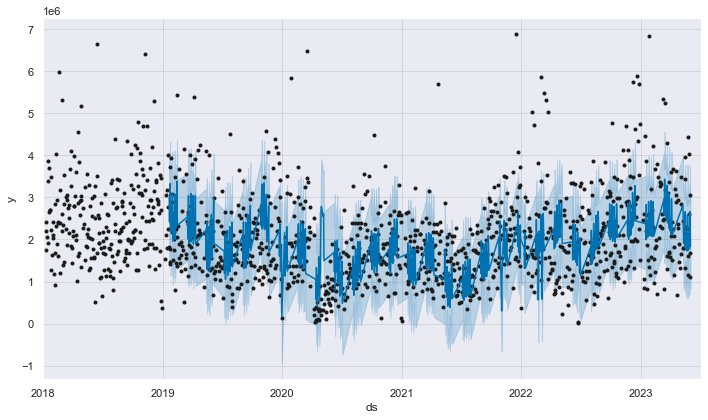

In [793]:
base_model.plot(base_validation)
plt.xlim(['2018-01-01', '2023-07-05'])

-------------------

In [742]:
# Обучим итоговую модель, гипперпараметры подбирались многократными итерациями через gridsearch
model = prophet.Prophet(holidays=holidays_data, changepoint_prior_scale=0.022)
model.add_regressor('Value', prior_scale=7)
model.add_regressor('dow', prior_scale=7)
for reg in train.columns:
    if reg.isnumeric():
        model.add_regressor(reg, prior_scale=0.5)
model.fit(train)

19:59:50 - cmdstanpy - INFO - Chain [1] start processing
19:59:51 - cmdstanpy - INFO - Chain [1] done processing


In [743]:
validation = cross_validation(model, horizon='28 days', period='112 days', initial = '365.25 days')

  0%|          | 0/15 [00:00<?, ?it/s]

19:59:51 - cmdstanpy - INFO - Chain [1] start processing
19:59:51 - cmdstanpy - INFO - Chain [1] done processing
19:59:53 - cmdstanpy - INFO - Chain [1] start processing
19:59:53 - cmdstanpy - INFO - Chain [1] done processing
19:59:54 - cmdstanpy - INFO - Chain [1] start processing
19:59:54 - cmdstanpy - INFO - Chain [1] done processing
19:59:55 - cmdstanpy - INFO - Chain [1] start processing
19:59:55 - cmdstanpy - INFO - Chain [1] done processing
19:59:56 - cmdstanpy - INFO - Chain [1] start processing
19:59:57 - cmdstanpy - INFO - Chain [1] done processing
19:59:58 - cmdstanpy - INFO - Chain [1] start processing
19:59:58 - cmdstanpy - INFO - Chain [1] done processing
19:59:59 - cmdstanpy - INFO - Chain [1] start processing
19:59:59 - cmdstanpy - INFO - Chain [1] done processing
20:00:01 - cmdstanpy - INFO - Chain [1] start processing
20:00:01 - cmdstanpy - INFO - Chain [1] done processing
20:00:02 - cmdstanpy - INFO - Chain [1] start processing
20:00:02 - cmdstanpy - INFO - Chain [1]

In [791]:
performance_metrics(validation).iloc[-1,][['mdape', 'coverage']]

mdape       0.331889
coverage    0.635714
Name: 19, dtype: object

-----------

In [777]:
# Финишно оценим точность модели на реальных данных
# Для прогноза нужно сделать прогноз курса валюты
curracy = prophet.Prophet(holidays=holidays_data)

In [778]:
cur = train.merge(Euro, how='left')

In [779]:
cur = cur[['ds', 'Value']].rename(columns={'Value':'y'})

In [780]:
curracy.fit(cur)

20:05:38 - cmdstanpy - INFO - Chain [1] start processing
20:05:41 - cmdstanpy - INFO - Chain [1] done processing


In [781]:
curracy_predict = curracy.predict(test)[['ds', 'yhat']]
curracy_predict = curracy_predict.rename(columns={'yhat': 'Value'})
curracy_predict.head(5)

In [784]:
# Итоговый прогноз
results = model.predict(test.merge(curracy_predict, how='left'))[['ds', 'yhat']]

In [785]:
results = results.merge(test, how='left')[['ds', 'yhat', 'y']]

In [786]:
# В выходные продаж не бывает, прогноз нужно вручную обнулить в дни выходных
results.loc[results.y == 0, 'yhat'] = 0

In [787]:
results

,ds,yhat,y
0,2023-06-03,0.000000e+00,0.00
1,2023-06-04,0.000000e+00,0.00
2,2023-06-05,2.695561e+06,4364980.90
3,2023-06-06,2.337651e+06,2215521.70
4,2023-06-07,3.254549e+06,4155429.63
5,2023-06-08,2.795543e+06,3303164.41
6,2023-06-09,2.439162e+06,2538544.92
7,2023-06-10,0.000000e+00,0.00
8,2023-06-11,0.000000e+00,0.00
9,2023-06-12,0.000000e+00,0.00


In [788]:
MAPE(results.y, results.yhat)

0.14498454723362378

(19358.0, 19543.0)

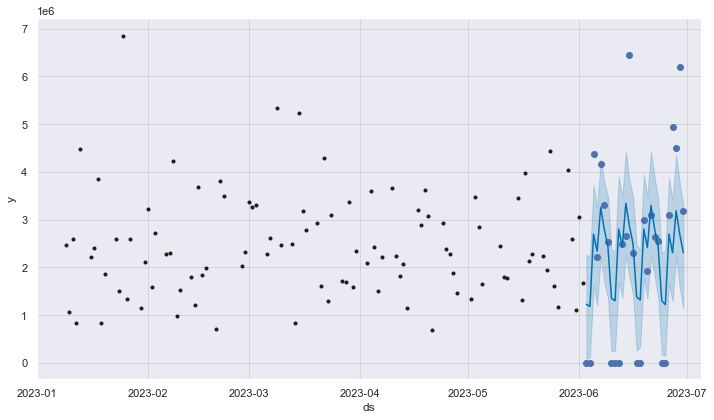

In [789]:
# Визуализация реальных точек и прогноза
model.plot(model.predict(test.merge(curracy_predict, how='left')))
plt.scatter(data = test, x='ds', y='y')
plt.xlim(['2023-01-01', '2023-07-05'])

Как выдим существуют постоянные открыввы - при анализе выяснили что, среднеоптовые покупки крупных клиентов которые случаются с разной периодичностью.

--------------